In [84]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image, write_jpeg
from torch.utils.data import Dataset
import torch
import sys
from collections import defaultdict
from tqdm import tqdm


def load_labels(path):
    df = pd.read_csv(path)
    return df


def load_image(path, idx, df):
    img_path = os.path.join(path, df.iloc[idx, 0] + '.jpg')
    image = read_image(img_path)

    return image


def transform_image(image):
    angle = random.randint(-180, 180)
    image = TF.rotate(image, angle)
    
    hflip_prob = random.randint(1, 10)
    if hflip_prob > 5:
        image = TF.hflip(image)
    
    vflip_prob = random.randint(1, 10)
    if vflip_prob > 5:
        image = TF.vflip(image)

    return image


def show_image(image):
    plt.imshow(  image.permute(1, 2, 0)  )
    
    
def append_df(df, labels):
    highest_idx = len(df) - 1
    
    # Sanity Check
    img_number = int(df.iloc[highest_idx]['image_name'].split('_')[1])
    if highest_idx != img_number:
        print(f"[-] We got out of sync at index {highest_idx}")
        print(f"{df.iloc[highest_idx]}")
        sys.exit(-1)
        
    new_idx = highest_idx + 1    
    new_row = {
        "image_name": [f"augment_{new_idx}"],
        "tags": [' '.join(labels)]
    }
    return_row = {
        "image_name": f"augment_{new_idx}",
        "tags": ' '.join(labels)
    }
    
    new_df = pd.concat([df, pd.DataFrame.from_dict(new_row)], ignore_index=True)
    return new_df, return_row


def save_image(base_path, img_name, img):
    path = os.path.join(base_path, img_name)
    write_jpeg(img, path, 100)

    
def get_labels(df, idx):
    labels = df.iloc[idx]['tags']
    return labels.strip().split(' ')


def get_score(labels, dist, max_val):
    label_scores = []
    for label in labels:
        label_scores += [ dist[label] ]

    most_common = max(label_scores)
    rarest = min(label_scores)

    score = (1 - rarest)
    return score, most_common


def get_label_dist(df):
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
    
    dist = defaultdict(int)
    for idx in range(len(df)):
        labels = df.iloc[idx]['tags'].strip().split(' ')
        for l in labels:
            dist[l] += 1
    
    for t in tags:
        dist[t] = dist[t] / len(df)
    
    return dist, sum(dist.values())

def get_augmented_label_dist(df):
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
    
    dist = defaultdict(int)
    for idx in range(len(df)):
        if not df.iloc[idx]['image_name'].startswith('augment'):
            continue
        labels = df.iloc[idx]['tags'].strip().split(' ')
        for l in labels:
            dist[l] += 1
    
    for t in tags:
        dist[t] = dist[t] / len(df)
    
    return dist, sum(dist.values())
    
def show_dist(df, title):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_axes([0,0,1,1])
    tags = list(df.keys())
    rate = list(df.values())
    bars = ax.bar(tags, rate)
    ax.set_ylabel('rate',fontsize= 12)
    ax.set_xlabel('tags',fontsize= 12)
    ax.set_xticklabels(tags, rotation=90)
    ax.set_title(title) 
    
    ax.bar_label(bars,[round(r*100, 2) for r in rate])

    plt.show()

    
def main():
    base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'
    
    csv_path = os.path.join(base_path, "train_classes.csv")
    img_base_path = os.path.join(base_path, "train-jpg")

    df = load_labels(csv_path)
    label_dist, max_val = get_label_dist(df)
    len_df = len(df)
    
    counter = 0
    for idx in tqdm(range(len_df)):
        trans_tags = df.iloc[idx]['tags'].split(' ')
        score, score_max = get_score(trans_tags, label_dist, max_val)
        if score < 0.5:
            continue

        #if df.iloc[idx]['image_name'].startswith('augment'):
        #    continue

        img = load_image(img_base_path, idx, df)
        for i in range(max(1, int((10 * (1-score_max))))):
            trans_img = transform_image(img)[:3,:,:]
            df, new_row = append_df(df, trans_tags)

            save_image(img_base_path, f"{new_row['image_name']}.jpg", trans_img)
            counter += 1

    with open(os.path.join(base_path, 'new_classes.csv'), 'w') as f:
        f.write(df.to_csv(index=False))
    
    print(f"Augmented {counter} images")

    df_new = load_labels(os.path.join(base_path, "new_classes.csv"))
    label_dist_new, max_val_new = get_label_dist(df_new)
    show_dist(label_dist, 'tag_distrib_old')
    show_dist(label_dist_new, 'tag_distrib_new')
    
    augmented_label_dist, _ = get_augmented_label_dist(df_new)
    show_dist(augmented_label_dist, 'augmented_dist')

In [85]:
main()

  4%|██████▉                                                                                                                                                                  | 1670/40479 [00:09<03:37, 178.77it/s]


KeyboardInterrupt: 

In [16]:
base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'

csv_path = os.path.join(base_path, "train_classes.csv")
img_base_path = os.path.join(base_path, "train-jpg")

df = load_labels(csv_path)
label_dist, max_val = get_label_dist(df)

df_new = load_labels(os.path.join(base_path, "new_classes.csv"))
label_dist_new, max_val_new = get_label_dist(df_new)


In [ ]:
show_dist(label_dist, 'old tags')
show_dist(label_dist_new, 'new tags')

In [81]:
for i in range(len(df)):
    labels =  df.iloc[i]['tags'].split(' ')
    if 'blow_down' in labels:
        score = get_score(labels, label_dist, max_val)
        print(f"{labels}: {score}")

['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['bare_ground', 'blow_down', 'clear', 'primary', 'slash_burn']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['partly_cloudy', 'primary', 'blow_down']: (0.9975048790730996, 0.9267274389189456)
['partly_cloudy', 'primary', 'blow_down']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear', 'primary']: (0.9975048790730996, 0.9267274389189456)
['agriculture', 'partly_cloudy', 'primary', 'blow_down']: (0.9975048790730996, 0.9267274389189456)
['blow_down', 'clear

defaultdict(<class 'int'>, {'cloudy': 0.04808378409483255, 'bare_ground': 0.004120151916215905, 'haze': 0.0006214754287029578, 'clear': 0.017562435262976177, 'water': 0.009437219472896765, 'habitation': 0.004396363217861664, 'road': 0.007895039705374612, 'partly_cloudy': 0.001979514328461273, 'agriculture': 0.007895039705374612, 'artisinal_mine': 0.00034526412705719877, 'cultivation': 0.000552422603291518, 'conventional_mine': 0.0001381056508228795, 'primary': 0.0, 'slash_burn': 0.0, 'blooming': 0.0, 'selective_logging': 0.0, 'blow_down': 0.0})
          image_name              tags
40479  augment_40479            cloudy
40480  augment_40480            cloudy
40481  augment_40481            cloudy
40482  augment_40482  bare_ground haze
40483  augment_40483            cloudy


/tmp/ipykernel_1608/1044761562.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


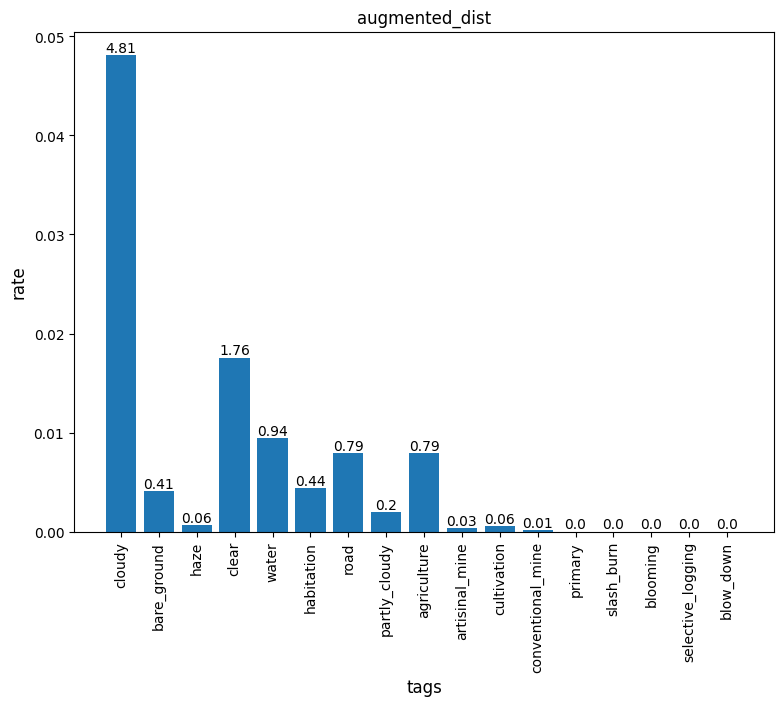

In [13]:
augmented_label_dist, _ = get_augmented_label_dist(df_new)
print(augmented_label_dist)
print(df_new.loc[df_new['image_name'].str.startswith('augment')].head())
show_dist(augmented_label_dist, 'augmented_dist')